In [1]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
!pip3 install wandb
!pip3 install torchsummary

#import os
import sys
import time
import math
import shutil 

import torch.nn as nn
import torch.nn.init as init

import wandb
import warnings
import torch

import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
import sys
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
wandb.init(project="TinyImagenet", name="Resnet50")



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrunal (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

_, term_width = shutil.get_terminal_size()
#_, term_width = os.popen('stty size', 'r').read().split()
term_width = int(term_width)

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time


def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)

pkgpath = './'
save_path = './results/'

if os.path.isdir(save_path) == False:
    os.makedirs(save_path)

sys.path.append(pkgpath)



device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
        transforms.RandomCrop(64, padding=8),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dir = '/scratch/mnk2978/hpml/finalproj_old/tiny-imagenet-200/train'

trainset = torchvision.datasets.ImageFolder(
    train_dir, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=0)

test_dir = '/scratch/mnk2978/hpml/finalproj_old/tiny-imagenet-200/val/images'
testset = torchvision.datasets.ImageFolder(
    test_dir, transform=transform_test) 
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=0)
classes = 200
img_size = 64

# Model
print('==> Building model..')
import torchvision.models as models

from torchvision.models.resnet import ResNet, Bottleneck

num_classes = 200

print(ResNet)
    
net = models.resnet50()


#Finetune Final few layers to adjust for tiny imagenet input
net.avgpool = nn.AdaptiveAvgPool2d(1)
net.fc.out_features = 200
print

net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print(net)
#%%


==> Preparing data..
==> Building model..
<class 'torchvision.models.resnet.ResNet'>
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (

Epoch:0/90


/home/mnk2978/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


 [================================================================>]  Step: 1s820ms | Tot: 3m20s | train_Loss: 5.387 | train_Acc: 1.377% (1377/100000) 1000/1000 ..........]  Step: 204ms | Tot: 34s624ms | train_Loss: 6.414 | train_Acc: 0.739% (130/17600) 176/1000 ................]  Step: 205ms | Tot: 38s458ms | train_Loss: 6.318 | train_Acc: 0.738% (144/19500) 195/1000 ============================>....................................]  Step: 204ms | Tot: 1m28s | train_Loss: 5.744 | train_Acc: 0.872% (389/44600) 446/1000 
>>>best acc: 0, mean: 1.0, std: 0.0................................]  Step: 274ms | Tot: 1ms | test_Loss: 4.407 | test_Acc: 1.000% (1/100) 1/100 
>>>best acc: 0, mean: 0.75, std: 0.25..............................]  Step: 165ms | Tot: 166ms | test_Loss: 4.770 | test_Acc: 0.500% (1/200) 2/100 
>>>best acc: 0, mean: 0.61, std: 0.28..............................]  Step: 149ms | Tot: 315ms | test_Loss: 4.881 | test_Acc: 0.333% (1/300) 3/100 
>>>best acc: 0, mean: 0.52, std:

>>>best acc: 0, mean: 2.36, std: 0.92..............................]  Step: 153ms | Tot: 7s443ms | test_Loss: 4.956 | test_Acc: 2.765% (141/5100) 51/100 
>>>best acc: 0, mean: 2.37, std: 0.91..............................]  Step: 149ms | Tot: 7s592ms | test_Loss: 4.955 | test_Acc: 2.712% (141/5200) 52/100 
>>>best acc: 0, mean: 2.37, std: 0.9...............................]  Step: 144ms | Tot: 7s736ms | test_Loss: 4.961 | test_Acc: 2.660% (141/5300) 53/100 
>>>best acc: 0, mean: 2.38, std: 0.9>..............................]  Step: 147ms | Tot: 7s884ms | test_Loss: 4.961 | test_Acc: 2.722% (147/5400) 54/100 
>>>best acc: 0, mean: 2.39, std: 0.89>.............................]  Step: 158ms | Tot: 8s42ms | test_Loss: 4.971 | test_Acc: 2.673% (147/5500) 55/100 
>>>best acc: 0, mean: 2.39, std: 0.88>.............................]  Step: 166ms | Tot: 8s208ms | test_Loss: 4.967 | test_Acc: 2.625% (147/5600) 56/100 
>>>best acc: 0, mean: 2.4, std: 0.88==>............................]  Step: 1

>>>best acc: 2.81, mean: 13.5, std: 4.5............................]  Step: 115ms | Tot: 116ms | test_Loss: 4.310 | test_Acc: 9.000% (18/200) 2/100 
>>>best acc: 2.81, mean: 11.67, std: 4.5...........................]  Step: 115ms | Tot: 231ms | test_Loss: 4.391 | test_Acc: 8.000% (24/300) 3/100 
>>>best acc: 2.81, mean: 10.44, std: 4.44..........................]  Step: 116ms | Tot: 347ms | test_Loss: 4.420 | test_Acc: 6.750% (27/400) 4/100 
>>>best acc: 2.81, mean: 10.19, std: 4.0...........................]  Step: 114ms | Tot: 462ms | test_Loss: 4.353 | test_Acc: 9.200% (46/500) 5/100 
>>>best acc: 2.81, mean: 9.99, std: 3.68...........................]  Step: 113ms | Tot: 576ms | test_Loss: 4.363 | test_Acc: 9.000% (54/600) 6/100 
>>>best acc: 2.81, mean: 9.77, std: 3.45...........................]  Step: 113ms | Tot: 689ms | test_Loss: 4.348 | test_Acc: 8.429% (59/700) 7/100 
>>>best acc: 2.81, mean: 9.47, std: 3.32...........................]  Step: 104ms | Tot: 793ms | test_Loss

>>>best acc: 2.81, mean: 6.16, std: 1.93...........................]  Step: 130ms | Tot: 6s316ms | test_Loss: 4.533 | test_Acc: 5.109% (281/5500) 55/100 
>>>best acc: 2.81, mean: 6.14, std: 1.92...........................]  Step: 116ms | Tot: 6s433ms | test_Loss: 4.527 | test_Acc: 5.161% (289/5600) 56/100 
>>>best acc: 2.81, mean: 6.12, std: 1.9............................]  Step: 122ms | Tot: 6s555ms | test_Loss: 4.524 | test_Acc: 5.088% (290/5700) 57/100 
>>>best acc: 2.81, mean: 6.11, std: 1.89...........................]  Step: 121ms | Tot: 6s677ms | test_Loss: 4.516 | test_Acc: 5.397% (313/5800) 58/100 
>>>best acc: 2.81, mean: 6.1, std: 1.88>...........................]  Step: 118ms | Tot: 6s796ms | test_Loss: 4.512 | test_Acc: 5.559% (328/5900) 59/100 
>>>best acc: 2.81, mean: 6.09, std: 1.86>..........................]  Step: 116ms | Tot: 6s913ms | test_Loss: 4.507 | test_Acc: 5.667% (340/6000) 60/100 
>>>best acc: 2.81, mean: 6.08, std: 1.85=>.........................]  Step: 

>>>best acc: 7.43, mean: 21.98, std: 8.0...........................]  Step: 95ms | Tot: 492ms | test_Loss: 3.948 | test_Acc: 13.833% (83/600) 6/100 
>>>best acc: 7.43, mean: 21.14, std: 7.68..........................]  Step: 96ms | Tot: 589ms | test_Loss: 3.993 | test_Acc: 16.143% (113/700) 7/100 
>>>best acc: 7.43, mean: 20.45, std: 7.41..........................]  Step: 133ms | Tot: 722ms | test_Loss: 3.963 | test_Acc: 15.625% (125/800) 8/100 
>>>best acc: 7.43, mean: 19.88, std: 7.17..........................]  Step: 95ms | Tot: 817ms | test_Loss: 3.993 | test_Acc: 15.333% (138/900) 9/100 
>>>best acc: 7.43, mean: 19.43, std: 6.94..........................]  Step: 99ms | Tot: 917ms | test_Loss: 3.952 | test_Acc: 15.300% (153/1000) 10/100 
>>>best acc: 7.43, mean: 18.96, std: 6.78..........................]  Step: 100ms | Tot: 1s17ms | test_Loss: 4.065 | test_Acc: 14.273% (157/1100) 11/100 
>>>best acc: 7.43, mean: 18.57, std: 6.62..........................]  Step: 98ms | Tot: 1s116m

>>>best acc: 7.43, mean: 14.82, std: 3.56..........................]  Step: 101ms | Tot: 5s922ms | test_Loss: 4.122 | test_Acc: 14.136% (834/5900) 59/100 
>>>best acc: 7.43, mean: 14.81, std: 3.53..........................]  Step: 97ms | Tot: 6s20ms | test_Loss: 4.106 | test_Acc: 14.383% (863/6000) 60/100 
>>>best acc: 7.43, mean: 14.8, std: 3.5==>.........................]  Step: 99ms | Tot: 6s119ms | test_Loss: 4.109 | test_Acc: 14.213% (867/6100) 61/100 
>>>best acc: 7.43, mean: 14.79, std: 3.47>.........................]  Step: 100ms | Tot: 6s220ms | test_Loss: 4.123 | test_Acc: 13.984% (867/6200) 62/100 
>>>best acc: 7.43, mean: 14.78, std: 3.45=>........................]  Step: 99ms | Tot: 6s320ms | test_Loss: 4.119 | test_Acc: 14.095% (888/6300) 63/100 
>>>best acc: 7.43, mean: 14.76, std: 3.42=>........................]  Step: 96ms | Tot: 6s417ms | test_Loss: 4.124 | test_Acc: 13.891% (889/6400) 64/100 
>>>best acc: 7.43, mean: 14.75, std: 3.4===>.......................]  Step:

KeyboardInterrupt: 

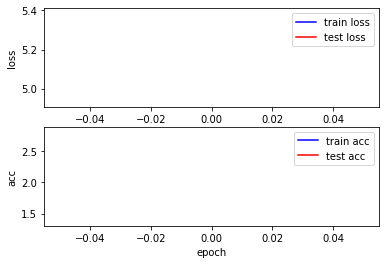

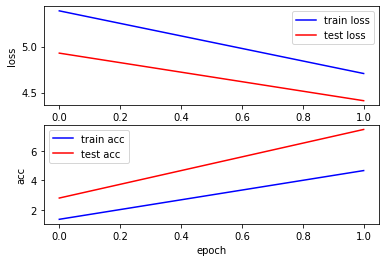

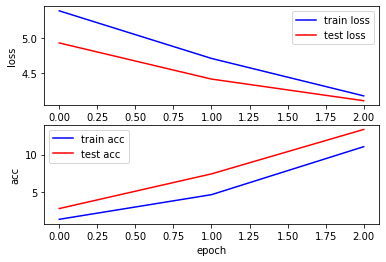

In [7]:
# Training
wandb.watch(net)


epochs = 90
def train(epoch):
    print('Epoch:{0}/{1}'.format(epoch, epochs))
    net.train()
    
    train_loss = 0 
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)        
        loss = criterion(outputs, targets)       
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'train_Loss: %.3f | train_Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    return train_loss/(batch_idx+1), 100.*correct/total

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    acc_list = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc_list.append(100.*correct/total)
            
            progress_bar(batch_idx, len(testloader), 'test_Loss: %.3f | test_Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            print('>>>best acc: {0}, mean: {1}, std: {2}'.format(best_acc, round(np.mean(acc_list), 2), round(np.std(acc_list), 2)))
            
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(save_path+'/checkpoint'):
            os.mkdir(save_path+'/checkpoint')
        torch.save(state, save_path+'/checkpoint/ckpt.pth')
        best_acc = acc
        print('>>>best acc:', best_acc)
    
    return test_loss/(batch_idx+1), 100.*correct/total, best_acc

test_loss = 0
test_list = []
train_list = []
epoch_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(start_epoch, start_epoch+epochs):
   
    epoch_list.append(epoch)
    
    train_loss, train_acc = train(epoch)
    train_list.append(train_loss)
    train_acc_list.append(train_acc)
    
    test_loss, test_acc, best_acc = test(epoch)
    test_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    epoch_line = 'epoch: {0}/ total epoch: {1} '.format(epoch, epochs) 
    best_acc_line = 'best_acc: {0} '.format(best_acc)
    accuracy_line = 'train_acc: {0} %, test_acc: {1} % '.format(train_acc, test_acc)
    loss_line = 'train_loss: {0},e test_loss: {1} '.format(train_loss, test_loss)
    wandb.log({"train accuracy" : train_acc, "test accuracy" : test_acc, "train_loss" : train_loss, "test_loss" : test_loss}, step=epoch+1)

    if epoch % 1 == 0:
        plt.figure()
        ax1 = plt.subplot(2, 1, 1)
        ax1.plot(epoch_list, train_list, c = 'blue', label = 'train loss')
        ax1.plot(epoch_list, test_list, c = 'red', label = 'test loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        ax1.legend(loc=0)
        
        ax2 = plt.subplot(2, 1, 2)
        ax2.plot(epoch_list, train_acc_list, c = 'blue', label = 'train acc')
        ax2.plot(epoch_list, test_acc_list, c = 'red', label = 'test acc')
        plt.ylabel('acc')
        plt.xlabel('epoch')
        ax2.legend(loc=0)
        
        plt.savefig(save_path+'/train_history.png')

    
    with open(save_path+'/logs.txt', 'a') as f:
        f.write(epoch_line + best_acc_line + accuracy_line + loss_line + '\n')
    scheduler.step()
